In [1]:
# import the necessary packages
from collections import deque
from imutils.video import VideoStream
from matplotlib import pyplot as plt
from skimage import morphology
from PIL import Image
import time
from copy import deepcopy

import numpy as np
import argparse
import cv2
import imutils
import time

In [2]:
## Helper Functions for displaying image and scaling
def scale_img(img, scale_percent):
    #print("\nscale_img()")
    #print(img.shape)
    
    # Scaled Image Dimensions
    width  = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #print(img.shape)
    return img

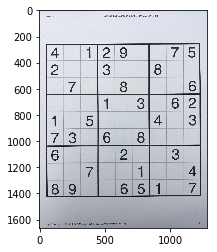

In [3]:
## Read in a File
frame = cv2.imread('sample3.jpg', cv2.IMREAD_COLOR) # Read the file
sf = 0.5
scaled = scale_img(frame, sf*100)
rgb = cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB)
plt.imshow(scaled)
plt.show()

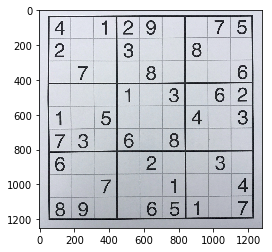

In [4]:
## Crop the image (1)
# crop_img = frame[y:y+h, x:x+w].copy()
crop_img = scaled[ int(sf*450):int(sf*2950), int(sf*5):int(sf*2900) ].copy()
plt.imshow(crop_img)
plt.show()

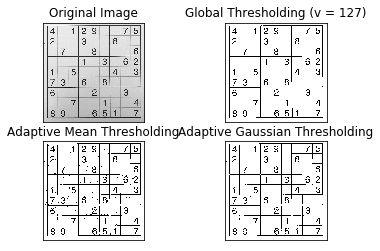

In [5]:
# Convert to Binary
# https://techtutorialsx.com/2019/04/13/python-opencv-converting-image-to-black-and-white/
gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray,5)

ret, th1 = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
# need the one below
th3 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
         'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [gray, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1), plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
    
plt.show()
#gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#(thresh, binary) = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
#edgeMap = imutils.auto_canny(gray)
#plt.imshow(binary, cmap='gray')
#plt.show()

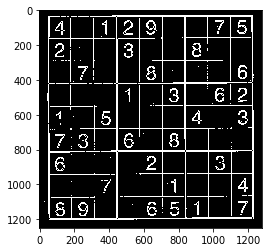

In [6]:
# Remove Noise
# https://scikit-image.org/docs/0.9.x/api/skimage.morphology.html#remove-small-objects
cleaned = morphology.remove_small_objects(th3, min_size=64, connectivity=1)
invert = (255-cleaned)

plt.imshow(invert,cmap='gray')
plt.show()

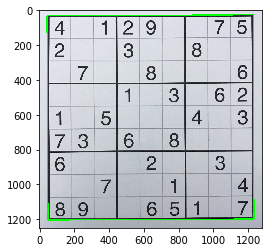

In [7]:
# find contours in the mask and draw largest enclosing rect
cnts = cv2.findContours(invert.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
center = None

#for c in cnts:
if len(cnts) > 0:
    #index = cnts.index(max(cnts, key=cv2.contourArea))
    #print(index)
    #cnts.pop(index)
    c = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(crop_img, [box], 0,(0,255,0),5)

plt.imshow(crop_img)

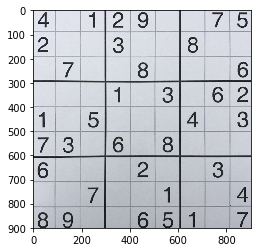

In [8]:
rect = np.float32(box)
dst = np.float32(np.asarray([[0, 930], [0, 0], [930, 0], [930, 930]]))
M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(crop_img, M, (930, 930))[15:915,15:915]
plt.imshow(warped)

In [9]:
# templates = cv2.imread('template0.jpg')
# templates = [templates [cv2.imread('template1.jpg')]]
# gray_box  = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
# plt.imshow(gray_box)
# plt.imshow(template0)
template0  = cv2.imread('template0.jpg') 
template1  = cv2.imread('template1.jpg')
template2  = cv2.imread('template2.jpg')
template3  = cv2.imread('template3.jpg')
template4  = cv2.imread('template4.jpg')
template5  = cv2.imread('template5.jpg')
template6  = cv2.imread('template6.jpg')
template7  = cv2.imread('template7.jpg')
template8  = cv2.imread('template8.jpg')
template9  = cv2.imread('template9.jpg')
templates  = np.asarray([template0, template1, template2, template3, template4, template5, template6, template7, template8, template9])

# gtemplate0 = cv2.cvtColor(template0, cv2.COLOR_BGR2GRAY)
# gtemplate1 = cv2.cvtColor(template1, cv2.COLOR_BGR2GRAY)
# gtemplate2 = cv2.cvtColor(template2, cv2.COLOR_BGR2GRAY)
# gtemplate3 = cv2.cvtColor(template3, cv2.COLOR_BGR2GRAY)
# gtemplate4 = cv2.cvtColor(template4, cv2.COLOR_BGR2GRAY)
# gtemplate5 = cv2.cvtColor(template5, cv2.COLOR_BGR2GRAY)
# gtemplate6 = cv2.cvtColor(template6, cv2.COLOR_BGR2GRAY)
# gtemplate7 = cv2.cvtColor(template7, cv2.COLOR_BGR2GRAY)
# gtemplate8 = cv2.cvtColor(template8, cv2.COLOR_BGR2GRAY)
# gtemplate9 = cv2.cvtColor(template9, cv2.COLOR_BGR2GRAY)
# gtemplates = np.asarray([gtemplate0,gtemplate1,gtemplate2,gtemplate3,gtemplate4,gtemplate5,gtemplate6,gtemplate7,gtemplate8,gtemplate9])


In [10]:
def get_square(img, x, y):
    lil_square = img[(y-1)*100:((y-1)+1)*100 - 1,(x-1)*100:((x-1)+1)*100 - 1]
    return lil_square    

In [70]:
def get_correlation_xy(image, x, y, template):
#     tiny_box = get_square(image, x, y)[5:95,5:95]
    tiny_box = get_square(image, x, y)
    correlation_out = cv2.matchTemplate(template, tiny_box, cv2.TM_SQDIFF_NORMED)
    return np.min(correlation_out)

In [68]:
def detect_number(image, x, y, templates):
    match = np.zeros(9)
    for i in range(9):
        match[i] = get_correlation_xy(image, x, y, templates[i])
    number = np.argmin(match)
    return number
    

In [22]:
def get_sudoku_matrix(image, templates):
    match = np.zeros((9,9))
    for y in range(1,10):
        for x in range(1,10):
            match[x-1,y-1] = detect_number(image, y, x, templates)
    return match
            

In [23]:
def solveSudoku(container):
# using explicit solver

    unsolvedSudoku = deepcopy(container)
    start = time.time()
    zero_count = 0
    for l in container:
        for v in l:
            if v == 0:
                zero_count += 1

    solving = True


    while solving:
        #Solver Portion
        container, stump_count = explicit_solver(container)

        #Loop-Breaking Portion
        zero_count = 0
        for l in container:
            for v in l:
                if v == 0:
                    zero_count += 1
        if zero_count==0:
    #         print_container(container)
            solving=False
        if stump_count > 0:
            for i in range(9):
                for j in range(9):
                    container = implicit_solver(i,j,container)

    print('That took ' + str(time.time()-start) + ' seconds!')
    
    # only return numbers to be projected
    projectSudoku = np.subtract(container, unsolvedSudoku)
    return projectSudoku

In [24]:
###  Defining Functions  ###
# helper functions
subtract_set = {1,2,3,4,5,6,7,8,9}

def check_horizontal(i,j):
    return subtract_set - set(container[i])

def check_vertical(i,j):
    ret_set = []
    for x in range(9):
        ret_set.append(container[x][j])
    return subtract_set - set(ret_set)

def check_square(i,j):
    first = [0,1,2]
    second = [3,4,5]
    third = [6,7,8]
    find_square = [first,second,third]
    for l in find_square:
        if i in l:
            row = l
        if j in l:
            col = l
    ret_set = []
    for x in row:
        for y in col:
            ret_set.append(container[x][y])
    return subtract_set - set(ret_set)

def get_poss_vals(i,j):
    poss_vals = list(check_square(i,j).intersection(check_horizontal(i,j)).intersection(check_vertical(i,j)))
    return poss_vals

def explicit_solver(container):
    # attempts to solve entire sudoku puzzle
    stump_count = 1
    for i in range(9):
        for j in range(9):
            if container[i][j] == 0:
                poss_vals = get_poss_vals(i,j)
                if len(poss_vals) == 1:
                    container[i][j] = list(poss_vals)[0]
#                     print_container(container)
                    stump_count = 0
    return container, stump_count

def implicit_solver(i,j,container):
    # attempts to solve a position in sudoku puzzle
    if container[i][j] == 0:
        poss_vals = get_poss_vals(i,j)
        
        #check row
        row_poss = []
        for y in range(9):
            if y == j:
                continue
            if container[i][y] == 0:
                for val in get_poss_vals(i,y):
                    row_poss.append(val)
        if len(set(poss_vals)-set(row_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(row_poss))[0]
        
        #check column
        col_poss = []
        for x in range(9):
            if x == i:
                continue
            if container[x][j] == 0:
                for val in get_poss_vals(x,j):
                    col_poss.append(val)
        if len(set(poss_vals)-set(col_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(col_poss))[0]
                
        #check square
        first = [0,1,2]
        second = [3,4,5]
        third = [6,7,8]
        find_square = [first,second,third]
        for l in find_square:
            if i in l:
                row = l
            if j in l:
                col = l
        square_poss = []
        for x in row:
            for y in col:
                if container[x][y] == 0:
                    for val in get_poss_vals(x,y):
                        square_poss.append(val)
        if len(set(poss_vals)-set(square_poss)) == 1:
            container[i][j] = list(set(poss_vals)-set(square_poss))[0]
    return container

def print_container(container):
    container = np.asarray(container) 
    for i in range(9):
        if i%3 == 0:
            print('-------------------------------')
        print('| ' + str(container[i][0:3]) + ' | ' + str(container[i][3:6]) + ' | '  + str(container[i][6:9]) + ' |')

    print('-------------------------------')

In [71]:
# RUN THIS FOR SUDOKU

sudoku = np.uint8(get_sudoku_matrix(warped, templates))
print_container(sudoku)


-------------------------------
| [4 0 1] | [2 0 0] | [0 7 5] |
| [2 0 0] | [3 0 0] | [8 0 0] |
| [0 7 0] | [0 8 0] | [0 0 0] |
-------------------------------
| [0 0 0] | [1 0 3] | [0 6 2] |
| [1 0 5] | [0 0 0] | [4 0 0] |
| [7 3 0] | [6 0 8] | [0 0 0] |
-------------------------------
| [6 0 0] | [0 2 0] | [0 3 0] |
| [0 0 7] | [0 0 1] | [0 0 0] |
| [0 0 0] | [0 8 0] | [1 0 7] |
-------------------------------


In [63]:
# RUN THIS TO SOLVE ONLY IF INPUT MATRIX IS RIGHT
# ELSE IT NEVER SOLVES BECAUSE INPUT IS WRONG
container = deepcopy(sudoku)
sudoku_missing = solveSudoku(container)
print(sudoku)
print(sudoku_missing)

KeyboardInterrupt: 

In [182]:
# TESTING

print(detect_number(warped, 9, 1, templates))


5


In [10]:
# DO NOT DELETE!!!

# # generate templates for matching
# # 9
# tmp = get_square(warped, 5, 1)
# template = tmp[7:77,19:89]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template9.jpg', template)
#
# # 8
# tmp = get_square(warped, 5, 3)
# template = tmp[13:83,19:89]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template8.jpg', template)
#
# # 7
# tmp = get_square(warped, 3, 8)
# template = tmp[30:100,12:82]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template7.jpg', template)
#
# # 6
# tmp = get_square(warped, 4, 6)
# template = tmp[21:91,17:87]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template6.jpg', template)
#
# # 5
# tmp = get_square(warped, 3, 5)
# template = tmp[19:89,15:85]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template5.jpg', template)
#
# # 4
# tmp = get_square(warped, 1, 1)
# template = tmp[5:75,8:78]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template4.jpg', template)
#
# # 3
# tmp = get_square(warped, 4, 2)
# template = tmp[10:80,17:87]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template3.jpg', template)
#
# # 2
# tmp = get_square(warped, 1, 2)
# template = tmp[8:78,7:77]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template2.jpg', template)
#
# # 1
# tmp = get_square(warped, 3, 1)
# template = tmp[5:75,14:84]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# plt.imshow(template, cmap='gray')
# cv2.imwrite('template1.jpg', template)
#
# # 0
# tmp = get_square(warped, 5, 2)
# template = tmp[7:77,19:89]
# gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# ret, template = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
# template[template<ret] = 0
# # plt.imshow(template, cmap='gray')
# cv2.imwrite('template0.jpg', template)
#

75805650.0
21094290.0
<type 'numpy.uint8'>
<type 'numpy.uint8'>


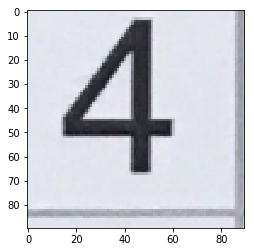

In [16]:
# FOR TESTING



# for y in range(1,10):
#     for x in range(1,10):
template = cv2.imread('template1.jpg')
x = 1
y = 1

tiny_box = get_square(warped, x, y)[5:95,5:95]
correlation_out = cv2.matchTemplate(template, tiny_box, cv2.cv2.TM_SQDIFF)
plt.imshow(tiny_box)

print(np.min(correlation_out))

template = cv2.imread('template4.jpg')
correlation_out = cv2.matchTemplate(template, tiny_box, cv2.cv2.TM_SQDIFF)
plt.imshow(tiny_box)
print(np.min(correlation_out))

print(type(tiny_box[0,0][0]))
print(type(template[0,0][0]))
